# Overview

This project is on Fraud detecion on mobile apps advertisment. click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money.The dataset for this project was gotten from kaggle competition on "TalkingData AdTracking Fraud detection" held 2 years ago.

### 1. Description:
TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

### 2. Data: 
The dataset on kaggle consists of the :
* Sample submission
* Training data
* Test data
* Test_supplement and
* Train_sample 

I downloaded the `Train_sample.csv` data because it is the lowest in size about 40 mb and contained about 100,000 observations and the main training data being 7gigabytes, test data about 2 gigabytes which is too much for this project and would definitely slow down my machine(PC). So in this `Final Capstone Project`, i will be using the `Train_sample.csv data`.

Link to dowload the full data for your own use: 
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

### 3. Evaluation Metric:
The evaluation metric used in this project is the `Area Under Curve`.
Link to resources on learning about `Area under Curve` :
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=AUC%20represents%20the%20probability%20that,has%20an%20AUC%20of%201.0.




*** just blank space ***

## Steps in completing this project:

* Importing all our packages/tools
* Read our data into the pandas data frame
* Carry out EDA( Exploratory Data Analysis) to understand our data
* Feature Engineering,selection  and analysis
* Modeling
* Hyperparameter Tuning
* Training the whole data on the best algorithm with best hyperparameter
* save our trained model using the `pickle` library
* make predictions/Evaluations on our test data
* feature importance

### Importing all our packages/tools

In [1]:
# importing the neccessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to view plots in our notebooks
%matplotlib inline

# for collecting unused varibles
import gc

# 1. importing the models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 2. importing the `Esemble` methods models
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Evaluation metrics tools
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score



### Read our data into the pandas data frame

In [2]:
fraud=pd.read_csv('train_sample.csv',low_memory=False)
fraud.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


#### let's check the data type of the `click time`

In [3]:
fraud.click_time.dtypes

dtype('O')

In [4]:
# Now we need to change the click time to its appropriate data type ("the time series data types")

fraud=pd.read_csv("train_sample.csv",low_memory=False,parse_dates=['click_time'])
fraud.click_time.dtypes

dtype('<M8[ns]')

In [5]:
fraud.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
fraud.isna().mean()

ip                 0.00000
app                0.00000
device             0.00000
os                 0.00000
channel            0.00000
click_time         0.00000
attributed_time    0.99773
is_attributed      0.00000
dtype: float64

From the above analysis, the attributed time contains a 99.7% missing values, we can safely jus drop that columns. So, let's do that! yipeeeeee!

In [7]:
fraud.drop('attributed_time',axis=1,inplace=True)

In [8]:
fraud.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [9]:
# now let's check the fields with missing columns
fraud.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

### from the immediate above analysis, there are no missing values, so our data is good.Next, let's do Exploratory data analysis on our features


## Carry out EDA( Exploratory Data Analysis) to understand our data

In [10]:
fraud.is_attributed.value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

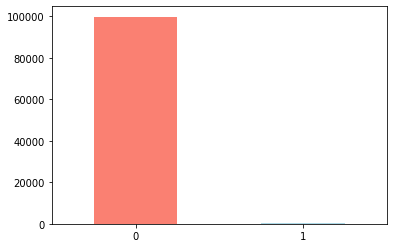

In [11]:
# let's visualize the above in a plot

fraud['is_attributed'].value_counts().plot(kind='bar',color=['salmon','lightblue'])
plt.xticks(rotation=0);

#### the target class is highly imbalanced, which is going to be a big issue...anyways we are gonna fix that soon.Only about 0.2% of clicks are 'fraudulent'

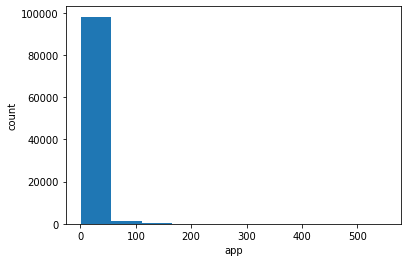

In [12]:
# let's check the distribution of the "app" feature

fraud['app'].plot.hist()
plt.xlabel('app')
plt.ylabel('count')
plt.show();


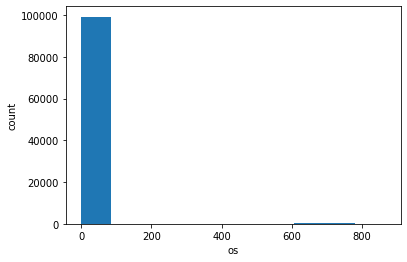

In [13]:
# let's check the distribution of the "os" feature
fraud['os'].plot.hist()
plt.xlabel('os')
plt.ylabel('count')
plt.show();



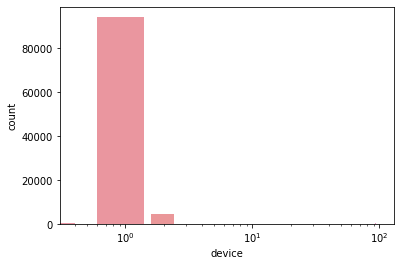

In [14]:
sns.countplot(x='device',data=fraud)
plt.xscale('log')

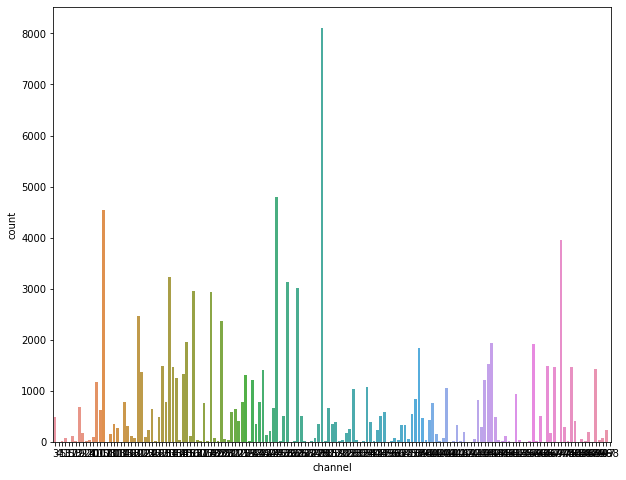

In [15]:
# # channel: various channels get clicks in comparable quantities
plt.figure(figsize=(10, 8))
sns.countplot(x="channel", data=fraud)

# Feature Engineering,selection and analysis

#### Let's check the correlation of the features with the target variables and other variables

In [16]:
fraud_corr=fraud.corr()
fraud_corr

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563,0.054955
app,0.010400,1.000000,0.248376,0.247160,-0.028238,0.064426
device,-0.001499,0.248376,1.000000,0.924456,-0.035398,-0.000695
os,-0.000470,0.247160,0.924456,1.000000,-0.033175,0.006183
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000,-0.023336
is_attributed,0.054955,0.064426,-0.000695,0.006183,-0.023336,1.000000


### let's make it more readable by visualizing it in a plot
* in this case, we are going to make use of the seaborn's functionalities

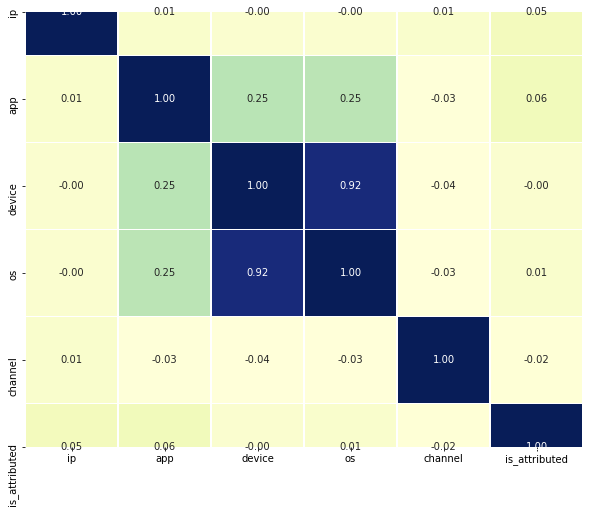

In [17]:
fig,ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(fraud_corr,
               cmap="YlGnBu",
               annot=True,
               fmt=".2f",
              linewidths=0.5,
              cbar=False)


 ### From the above plot, some values values are not aligning with the colors in the matrix, so we need to adjust it with the codes in the next cell.
 so we need to adjust the following:
 * the top values in the correlation matrix and
 * the bottom values in the correlation matrix

(6.0, 0.0)

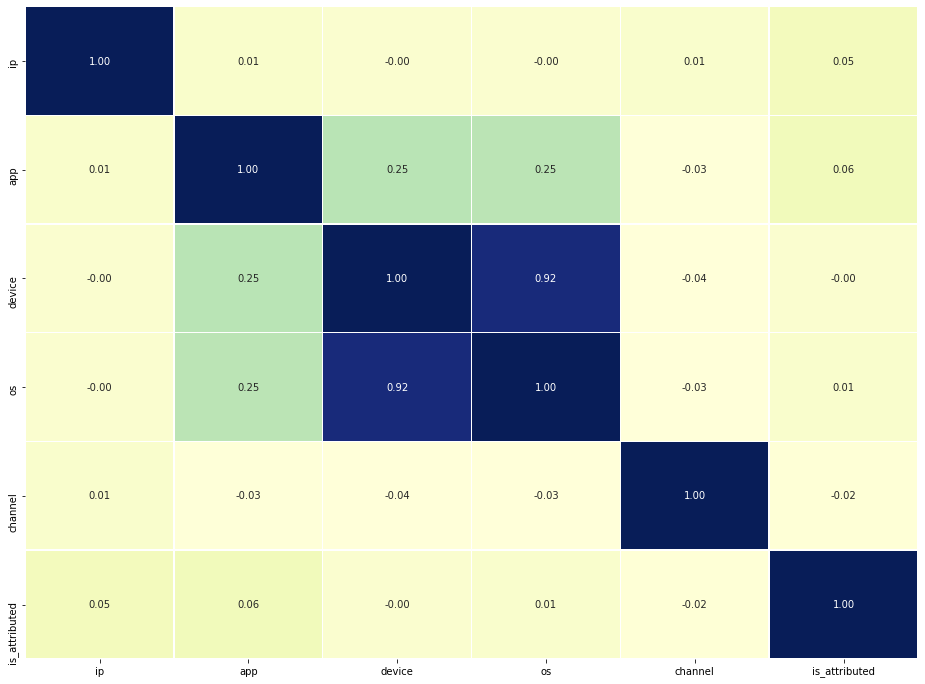

In [18]:
fig,ax=plt.subplots(figsize=(16,12))
ax=sns.heatmap(fraud_corr,
               annot=True,
               cmap="YlGnBu",
               cbar=False,fmt=".2f",
               linewidths=0.5)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+ 0.5, top- 0.5)

####  From above, there is a strong positive correlation between "device" and "os" features. This could impact the model perfomance we will build in future  by a problem known as multicolinearity.Although, Tree based algorithms are immune to this problem but algoritjms like Logistic Regression and KNN are not immune, so we will need to treat that before training our models.

There are many ways to do that, we will just simply delete one of the features

In [19]:
fraud.drop("device", axis=1,inplace=True)

In [20]:
fraud.head()

,ip,app,os,channel,click_time,is_attributed
0,87540,12,13,497,2017-11-07 09:30:38,0
1,105560,25,17,259,2017-11-07 13:40:27,0
2,101424,12,19,212,2017-11-07 18:05:24,0
3,94584,13,13,477,2017-11-07 04:58:08,0
4,68413,12,1,178,2017-11-09 09:00:09,0


### Feature Extraction/Engineering
##### we can extract some features from the "click_time" attribute. we can extract the "year","month","day","hour", combinations of other features etc. as will be seen soon

* ##### DateTime/Click-Time based Feature

In [21]:
fraud['day_of_year']=fraud['click_time'].dt.dayofyear
fraud['day_of_week']=fraud['click_time'].dt.dayofweek
fraud['month_of_click']=fraud['click_time'].dt.month
fraud['hour_of_click']=fraud['click_time'].dt.hour


In [22]:
fraud.drop('click_time',axis=1,inplace=True)
fraud.head()

,ip,app,os,channel,is_attributed,day_of_year,day_of_week,month_of_click,hour_of_click
0,87540,12,13,497,0,311,1,11,9
1,105560,25,17,259,0,311,1,11,13
2,101424,12,19,212,0,311,1,11,18
3,94584,13,13,477,0,311,1,11,4
4,68413,12,1,178,0,313,3,11,9


####  An important thing to note now is that we cannot use "ip" adress as a feature because if a new "ip" appears in our test data, our model wont be able to predict it."ip" is jus a categorical feature and has only being encoded.We are going to derive new features from the"ip" adress like "ip" count, "ip_os_hour","ip_channel_hour" etc.

### IP Grouping Based Feature

In [23]:
def grouping_based_feature(df):
    """
    Note: since the "ip" feature doesnt tell much because it has already being encoded into numbers, we will generate new features such as ip_count,ip count for each os and so on
    """
    
    ip_count = df.groupby('ip').size().reset_index(name='ip_count')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour_of_click']).size().reset_index(name='ip_day_hour')
    ip_hour_channel = df.groupby(['ip', 'hour_of_click', 'channel']).size().reset_index(name='ip_hour_channel')
    ip_hour_os = df.groupby(['ip', 'hour_of_click', 'os']).size().reset_index(name='ip_hour_os')
    ip_hour_app = df.groupby(['ip', 'hour_of_click', 'app']).size().reset_index(name='ip_hour_app')
    
    #let's merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour_of_click'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour_of_click', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour_of_click', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour_of_click', 'app'], how='left')
    del ip_hour_app
   
    
    return df

In [24]:
fraud=grouping_based_feature(fraud)

In [25]:
fraud.head()

,ip,app,os,channel,is_attributed,day_of_year,day_of_week,month_of_click,hour_of_click,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app
0,87540,12,13,497,0,311,1,11,9,8,1,1,1,1
1,105560,25,17,259,0,311,1,11,13,149,4,1,1,1
2,101424,12,19,212,0,311,1,11,18,2,1,1,1,1
3,94584,13,13,477,0,311,1,11,4,3,1,1,1,1
4,68413,12,1,178,0,313,3,11,9,4,1,1,1,1


In [26]:
# gabbage collector(collects the unused objects)
gc.collect()

23012

## Modelling

In this section, we are going to try different algorithms, ranging from :
* Logistic Regresions
* Logistic Regressions
* Ensembles( Random Forests and CatBoostClassifier)

Before that, we need to split our data, into train,validation_set and test_set.From the kaggle competition, the test_set has been provided but its too large and would slow down our machine, so in this case we will generate the validation data and test data from the train_sample data. afterwards we:

* train our model on the train_set
* carry out hyperparameter tuning and make local evaluations on the validation set
* evaluate our model on the test set

* Splitting our data

we are going to split the train_sample to a size of 70% of the total data while the validation data and test data would take 15% each

In [27]:
fraud=fraud.sample(frac=1)
train_len=int(0.7*len(fraud))
val_len=int(0.85*len(fraud))
x_train,y_train=fraud.drop("is_attributed",axis=1)[:train_len],fraud["is_attributed"][:train_len]
x_val,y_val=fraud.drop("is_attributed",axis=1)[train_len:val_len],fraud["is_attributed"][train_len:val_len]
x_test,y_test=fraud.drop("is_attributed",axis=1)[val_len:],fraud["is_attributed"][val_len:]

In [28]:
len(x_train),len(x_val),len(x_test)

(70000, 15000, 15000)

In [29]:
 models={"Logistics":LogisticRegression(),
           "KNN":KNeighborsClassifier(),
           "Random_forest":RandomForestClassifier(),
           "Catboost":CatBoostClassifier()
           }
    
def fit_and_score(models,x_train,y_train,x_val,y_val):
    """
    Note:This helper function fits and scores the baseline models with their default paramters
    """
   
    models_score={}
    
    for name,model in models.items():
        np.random.seed(42)
        
        model.fit(x_train[:25000],y_train[:25000])
        preds=model.predict_proba(x_val)[:,1]
        models_score[name]=metrics.roc_auc_score(y_val,preds)
        
    return models_score
        

In [30]:
models_score=fit_and_score(models,x_train,y_train,x_val,y_val)
models_score

C:\Users\proo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Learning rate set to 0.040724
0:	learn: 0.5781733	total: 168ms	remaining: 2m 47s
1:	learn: 0.4743967	total: 183ms	remaining: 1m 31s
2:	learn: 0.3955887	total: 200ms	remaining: 1m 6s
3:	learn: 0.3297772	total: 211ms	remaining: 52.5s
4:	learn: 0.2720546	total: 223ms	remaining: 44.3s
5:	learn: 0.2273055	total: 235ms	remaining: 38.9s
6:	learn: 0.1909640	total: 247ms	remaining: 35s
7:	learn: 0.1601753	total: 257ms	remaining: 31.9s
8:	learn: 0.1363279	total: 269ms	remaining: 29.6s
9:	learn: 0.1175562	total: 280ms	remaining: 27.7s
10:	learn: 0.1017365	total: 292ms	remaining: 26.2s
11:	learn: 0.0859250	total: 304ms	remaining: 25s
12:	learn: 0.0756324	total: 313ms	remaining: 23.7s
13:	learn: 0.0667377	total: 325ms	remaining: 22.9s
14:	learn: 0.0580310	total: 336ms	remaining: 22.1s
15:	learn: 0.0521729	total: 348ms	remaining: 21.4s
16:	learn: 0.0466876	total: 359ms	remaining: 20.8s
17:	learn: 0.0415117	total: 371ms	remaining: 20.3s
18:	learn: 0.0378946	total: 386ms	remaining: 19.9s
19:	learn: 0.

167:	learn: 0.0047577	total: 2.63s	remaining: 13s
168:	learn: 0.0047475	total: 2.64s	remaining: 13s
169:	learn: 0.0047335	total: 2.65s	remaining: 13s
170:	learn: 0.0046931	total: 2.67s	remaining: 12.9s
171:	learn: 0.0046753	total: 2.68s	remaining: 12.9s
172:	learn: 0.0046560	total: 2.69s	remaining: 12.9s
173:	learn: 0.0046358	total: 2.7s	remaining: 12.8s
174:	learn: 0.0046132	total: 2.71s	remaining: 12.8s
175:	learn: 0.0045951	total: 2.73s	remaining: 12.8s
176:	learn: 0.0045686	total: 2.74s	remaining: 12.7s
177:	learn: 0.0045467	total: 2.75s	remaining: 12.7s
178:	learn: 0.0045378	total: 2.76s	remaining: 12.7s
179:	learn: 0.0045321	total: 2.77s	remaining: 12.6s
180:	learn: 0.0045104	total: 2.79s	remaining: 12.6s
181:	learn: 0.0044984	total: 2.8s	remaining: 12.6s
182:	learn: 0.0044877	total: 2.81s	remaining: 12.6s
183:	learn: 0.0044833	total: 2.82s	remaining: 12.5s
184:	learn: 0.0044737	total: 2.84s	remaining: 12.5s
185:	learn: 0.0044616	total: 2.85s	remaining: 12.5s
186:	learn: 0.004450

329:	learn: 0.0029667	total: 4.62s	remaining: 9.38s
330:	learn: 0.0029618	total: 4.63s	remaining: 9.37s
331:	learn: 0.0029592	total: 4.64s	remaining: 9.35s
332:	learn: 0.0029474	total: 4.66s	remaining: 9.33s
333:	learn: 0.0029424	total: 4.67s	remaining: 9.31s
334:	learn: 0.0029361	total: 4.68s	remaining: 9.3s
335:	learn: 0.0029352	total: 4.69s	remaining: 9.28s
336:	learn: 0.0029327	total: 4.71s	remaining: 9.26s
337:	learn: 0.0029303	total: 4.72s	remaining: 9.24s
338:	learn: 0.0029237	total: 4.73s	remaining: 9.22s
339:	learn: 0.0029127	total: 4.74s	remaining: 9.2s
340:	learn: 0.0029031	total: 4.75s	remaining: 9.19s
341:	learn: 0.0029005	total: 4.76s	remaining: 9.17s
342:	learn: 0.0028978	total: 4.78s	remaining: 9.15s
343:	learn: 0.0028874	total: 4.79s	remaining: 9.13s
344:	learn: 0.0028848	total: 4.8s	remaining: 9.12s
345:	learn: 0.0028805	total: 4.81s	remaining: 9.1s
346:	learn: 0.0028738	total: 4.83s	remaining: 9.08s
347:	learn: 0.0028640	total: 4.84s	remaining: 9.07s
348:	learn: 0.00

499:	learn: 0.0020594	total: 7.05s	remaining: 7.05s
500:	learn: 0.0020546	total: 7.07s	remaining: 7.04s
501:	learn: 0.0020512	total: 7.08s	remaining: 7.02s
502:	learn: 0.0020491	total: 7.09s	remaining: 7s
503:	learn: 0.0020450	total: 7.1s	remaining: 6.99s
504:	learn: 0.0020395	total: 7.11s	remaining: 6.97s
505:	learn: 0.0020362	total: 7.13s	remaining: 6.96s
506:	learn: 0.0020311	total: 7.14s	remaining: 6.94s
507:	learn: 0.0020260	total: 7.15s	remaining: 6.92s
508:	learn: 0.0020256	total: 7.16s	remaining: 6.91s
509:	learn: 0.0020235	total: 7.17s	remaining: 6.89s
510:	learn: 0.0020161	total: 7.18s	remaining: 6.88s
511:	learn: 0.0020112	total: 7.2s	remaining: 6.86s
512:	learn: 0.0020100	total: 7.21s	remaining: 6.84s
513:	learn: 0.0020058	total: 7.22s	remaining: 6.83s
514:	learn: 0.0020050	total: 7.24s	remaining: 6.82s
515:	learn: 0.0020019	total: 7.25s	remaining: 6.8s
516:	learn: 0.0019944	total: 7.26s	remaining: 6.78s
517:	learn: 0.0019923	total: 7.27s	remaining: 6.77s
518:	learn: 0.0019

660:	learn: 0.0015507	total: 9.04s	remaining: 4.63s
661:	learn: 0.0015464	total: 9.05s	remaining: 4.62s
662:	learn: 0.0015461	total: 9.06s	remaining: 4.61s
663:	learn: 0.0015444	total: 9.08s	remaining: 4.59s
664:	learn: 0.0015442	total: 9.09s	remaining: 4.58s
665:	learn: 0.0015439	total: 9.1s	remaining: 4.56s
666:	learn: 0.0015433	total: 9.11s	remaining: 4.55s
667:	learn: 0.0015431	total: 9.12s	remaining: 4.53s
668:	learn: 0.0015400	total: 9.14s	remaining: 4.52s
669:	learn: 0.0015368	total: 9.15s	remaining: 4.5s
670:	learn: 0.0015340	total: 9.16s	remaining: 4.49s
671:	learn: 0.0015300	total: 9.17s	remaining: 4.48s
672:	learn: 0.0015299	total: 9.18s	remaining: 4.46s
673:	learn: 0.0015274	total: 9.2s	remaining: 4.45s
674:	learn: 0.0015257	total: 9.21s	remaining: 4.43s
675:	learn: 0.0015202	total: 9.22s	remaining: 4.42s
676:	learn: 0.0015173	total: 9.24s	remaining: 4.41s
677:	learn: 0.0015161	total: 9.25s	remaining: 4.39s
678:	learn: 0.0015140	total: 9.26s	remaining: 4.38s
679:	learn: 0.0

824:	learn: 0.0012379	total: 11.1s	remaining: 2.35s
825:	learn: 0.0012363	total: 11.1s	remaining: 2.33s
826:	learn: 0.0012332	total: 11.1s	remaining: 2.32s
827:	learn: 0.0012323	total: 11.1s	remaining: 2.31s
828:	learn: 0.0012305	total: 11.1s	remaining: 2.29s
829:	learn: 0.0012301	total: 11.1s	remaining: 2.28s
830:	learn: 0.0012244	total: 11.1s	remaining: 2.26s
831:	learn: 0.0012237	total: 11.1s	remaining: 2.25s
832:	learn: 0.0012233	total: 11.2s	remaining: 2.24s
833:	learn: 0.0012214	total: 11.2s	remaining: 2.22s
834:	learn: 0.0012201	total: 11.2s	remaining: 2.21s
835:	learn: 0.0012183	total: 11.2s	remaining: 2.2s
836:	learn: 0.0012149	total: 11.2s	remaining: 2.18s
837:	learn: 0.0012105	total: 11.2s	remaining: 2.17s
838:	learn: 0.0012088	total: 11.2s	remaining: 2.15s
839:	learn: 0.0012069	total: 11.2s	remaining: 2.14s
840:	learn: 0.0012027	total: 11.3s	remaining: 2.13s
841:	learn: 0.0012022	total: 11.3s	remaining: 2.12s
842:	learn: 0.0011977	total: 11.3s	remaining: 2.1s
843:	learn: 0.

996:	learn: 0.0009046	total: 13.5s	remaining: 40.6ms
997:	learn: 0.0009024	total: 13.5s	remaining: 27.1ms
998:	learn: 0.0009006	total: 13.5s	remaining: 13.5ms
999:	learn: 0.0008998	total: 13.5s	remaining: 0us


{'Logistics': 0.9034046707281068,
 'KNN': 0.5435028090311373,
 'Random_forest': 0.9775482233174366,
 'Catboost': 0.9894836425386659}

From above, KNN perfomed poorly while catboost, Logistics regression and RandomForest performed well. i am going to do hyperparameter tuning on RandomForestClassifier

## Hyperparamter Tuning

There are two search algorithms for hyperparameter Tuning, we have:

    *GridSearchCV : which performs exhuastive search on the parameters, this normally take longer than randomizedsearch
    
    * RandomizedSearchCV: which performs random search on the parameters for a given epoch(iteration)
In this section,we are going to do a RandomizedSearch on the hyperparameters on RandomForestClassifier

In [31]:
folds=5
rf_grid={'n_estimators':np.arange(10,100,10),
         'max_depth':[None,3,5,10],
         'min_samples_split':np.arange(2,20,2),
         'min_samples_leaf':np.arange(1,20,2),
         'max_features':[0.5,1,'sqrt','auto'],
         'max_samples':[10000]}
        

In [32]:
clf=RandomForestClassifier(n_jobs=1,random_state=42)
rs_randomforest=RandomizedSearchCV(clf,
                               param_distributions=rf_grid,
                               scoring="roc_auc",
                               return_train_score=False,
                               cv=folds,
                               verbose=100,
                               n_iter=100
                              )

rs_randomforest.fit(x_train[:25000],y_train[:25000])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=80, min_samples_split=14, min_samples_leaf=19, max_samples=10000, max_features=0.5, max_depth=5 
[CV]  n_estimators=80, min_samples_split=14, min_samples_leaf=19, max_samples=10000, max_features=0.5, max_depth=5, score=0.929, total=   0.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=14, min_samples_leaf=19, max_samples=10000, max_features=0.5, max_depth=5 
[CV]  n_estimators=80, min_samples_split=14, min_samples_leaf=19, max_samples=10000, max_features=0.5, max_depth=5, score=0.964, total=   0.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=14, min_samples_leaf=19, max_samples=10000, max_features=0.5, max_depth=5 
[CV]  n_estimators=80, min_samples_split=14, min_samples_leaf=19,

[CV]  n_estimators=40, min_samples_split=14, min_samples_leaf=15, max_samples=10000, max_features=sqrt, max_depth=10, score=0.968, total=   0.3s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.6s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=6, min_samples_leaf=19, max_samples=10000, max_features=1, max_depth=10 
[CV]  n_estimators=80, min_samples_split=6, min_samples_leaf=19, max_samples=10000, max_features=1, max_depth=10, score=0.950, total=   0.4s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   12.0s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=6, min_samples_leaf=19, max_samples=10000, max_features=1, max_depth=10 
[CV]  n_estimators=80, min_samples_split=6, min_samples_leaf=19, max_samples=10000, max_features=1, max_depth=10, score=0.961, total=   0.4s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.5s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=6, min_samples_leaf=19, max_samples=10000, max_features=1, max_dept

[CV]  n_estimators=80, min_samples_split=12, min_samples_leaf=9, max_samples=10000, max_features=1, max_depth=3, score=0.779, total=   0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.0s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=16, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=3 
[CV]  n_estimators=80, min_samples_split=16, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=3, score=0.917, total=   0.4s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:   21.4s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=16, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=3 
[CV]  n_estimators=80, min_samples_split=16, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=3, score=0.962, total=   0.4s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   21.8s remaining:    0.0s
[CV] n_estimators=80, min_samples_split=16, min_samples_leaf=17, max_samples=10000, max_features=sqr

[CV]  n_estimators=70, min_samples_split=14, min_samples_leaf=5, max_samples=10000, max_features=sqrt, max_depth=5, score=0.964, total=   0.4s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   33.3s remaining:    0.0s
[CV] n_estimators=30, min_samples_split=16, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=None 
[CV]  n_estimators=30, min_samples_split=16, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=None, score=0.945, total=   0.2s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   33.6s remaining:    0.0s
[CV] n_estimators=30, min_samples_split=16, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=None 
[CV]  n_estimators=30, min_samples_split=16, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=None, score=0.977, total=   0.2s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   33.8s remaining:    0.0s
[CV] n_estimators=30, min_samples_split=16, min_samples_leaf=1, max_samples=10000, max_fe

[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_samples=10000, max_features=auto, max_depth=None, score=0.909, total=   0.3s
[CV] n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=3 
[CV]  n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=3, score=0.919, total=   0.1s
[CV] n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=3 
[CV]  n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=3, score=0.937, total=   0.1s
[CV] n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=3 
[CV]  n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=3, score=0.909, total=   0.1s
[CV] n_estimators=20, min_samples_split=12, min_samples_leaf=11, max_sample

[CV]  n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10, score=0.968, total=   0.5s
[CV] n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10 
[CV]  n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10, score=0.939, total=   0.5s
[CV] n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10 
[CV]  n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10, score=0.928, total=   0.5s
[CV] n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10 
[CV]  n_estimators=70, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=auto, max_depth=10, score=0.975, total=   0.5s
[CV] n_estimators=70, min_samples_split=18, min_samples_leaf=17, max_samples

[CV]  n_estimators=20, min_samples_split=18, min_samples_leaf=13, max_samples=10000, max_features=1, max_depth=5, score=0.933, total=   0.1s
[CV] n_estimators=20, min_samples_split=18, min_samples_leaf=13, max_samples=10000, max_features=1, max_depth=5 
[CV]  n_estimators=20, min_samples_split=18, min_samples_leaf=13, max_samples=10000, max_features=1, max_depth=5, score=0.847, total=   0.1s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=None 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=None, score=0.918, total=   0.3s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=None 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=sqrt, max_depth=None, score=0.980, total=   0.3s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=1

[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None, score=0.928, total=   0.7s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None 
[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None, score=0.959, total=   0.6s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None 
[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None, score=0.928, total=   0.6s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None 
[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=15, max_samples=10000, max_features=auto, max_depth=None, score=0.922, total=   0.6s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=15

[CV]  n_estimators=10, min_samples_split=14, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=10, score=0.940, total=   0.1s
[CV] n_estimators=10, min_samples_split=14, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=10, min_samples_split=14, min_samples_leaf=1, max_samples=10000, max_features=sqrt, max_depth=10, score=0.897, total=   0.1s
[CV] n_estimators=20, min_samples_split=18, min_samples_leaf=7, max_samples=10000, max_features=0.5, max_depth=3 
[CV]  n_estimators=20, min_samples_split=18, min_samples_leaf=7, max_samples=10000, max_features=0.5, max_depth=3, score=0.934, total=   0.2s
[CV] n_estimators=20, min_samples_split=18, min_samples_leaf=7, max_samples=10000, max_features=0.5, max_depth=3 
[CV]  n_estimators=20, min_samples_split=18, min_samples_leaf=7, max_samples=10000, max_features=0.5, max_depth=3, score=0.960, total=   0.2s
[CV] n_estimators=20, min_samples_split=18, min_samples_leaf=7, max_samples=10000, m

[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5, score=0.930, total=   0.6s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5, score=0.962, total=   0.6s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5, score=0.903, total=   0.6s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=5, score=0.944, total=   0.7s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=17, max_samples

[CV]  n_estimators=80, min_samples_split=14, min_samples_leaf=5, max_samples=10000, max_features=1, max_depth=5, score=0.949, total=   0.4s
[CV] n_estimators=80, min_samples_split=14, min_samples_leaf=5, max_samples=10000, max_features=1, max_depth=5 
[CV]  n_estimators=80, min_samples_split=14, min_samples_leaf=5, max_samples=10000, max_features=1, max_depth=5, score=0.947, total=   0.4s
[CV] n_estimators=80, min_samples_split=14, min_samples_leaf=5, max_samples=10000, max_features=1, max_depth=5 
[CV]  n_estimators=80, min_samples_split=14, min_samples_leaf=5, max_samples=10000, max_features=1, max_depth=5, score=0.820, total=   0.4s
[CV] n_estimators=30, min_samples_split=6, min_samples_leaf=5, max_samples=10000, max_features=auto, max_depth=None 
[CV]  n_estimators=30, min_samples_split=6, min_samples_leaf=5, max_samples=10000, max_features=auto, max_depth=None, score=0.944, total=   0.2s
[CV] n_estimators=30, min_samples_split=6, min_samples_leaf=5, max_samples=10000, max_features

[CV]  n_estimators=80, min_samples_split=12, min_samples_leaf=15, max_samples=10000, max_features=0.5, max_depth=5, score=0.951, total=   0.7s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, max_features=auto, max_depth=5 
[CV]  n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, max_features=auto, max_depth=5, score=0.925, total=   0.5s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, max_features=auto, max_depth=5 
[CV]  n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, max_features=auto, max_depth=5, score=0.964, total=   0.3s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, max_features=auto, max_depth=5 
[CV]  n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, max_features=auto, max_depth=5, score=0.887, total=   0.3s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=19, max_samples=10000, 

[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10, score=0.933, total=   0.5s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10, score=0.890, total=   0.5s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10, score=0.896, total=   0.5s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=11, max_samples=10000, max_features=0.5, max_depth=10, score=0.943, total=   0.5s
[CV] n_estimators=20, min_samples_split=12, min_samples_leaf=19, max_samples=10000,

[CV]  n_estimators=80, min_samples_split=16, min_samples_leaf=7, max_samples=10000, max_features=sqrt, max_depth=10, score=0.915, total=   0.6s
[CV] n_estimators=80, min_samples_split=16, min_samples_leaf=7, max_samples=10000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=80, min_samples_split=16, min_samples_leaf=7, max_samples=10000, max_features=sqrt, max_depth=10, score=0.965, total=   0.6s
[CV] n_estimators=60, min_samples_split=8, min_samples_leaf=7, max_samples=10000, max_features=1, max_depth=10 
[CV]  n_estimators=60, min_samples_split=8, min_samples_leaf=7, max_samples=10000, max_features=1, max_depth=10, score=0.962, total=   0.3s
[CV] n_estimators=60, min_samples_split=8, min_samples_leaf=7, max_samples=10000, max_features=1, max_depth=10 
[CV]  n_estimators=60, min_samples_split=8, min_samples_leaf=7, max_samples=10000, max_features=1, max_depth=10, score=0.944, total=   0.3s
[CV] n_estimators=60, min_samples_split=8, min_samples_leaf=7, max_samples=10000, max_featur

[CV]  n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None, score=0.945, total=   1.1s
[CV] n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None 
[CV]  n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None, score=0.936, total=   1.3s
[CV] n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None 
[CV]  n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None, score=0.938, total=   1.0s
[CV] n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None 
[CV]  n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_samples=10000, max_features=0.5, max_depth=None, score=0.940, total=   0.9s
[CV] n_estimators=90, min_samples_split=18, min_samples_leaf=3, max_s

[CV]  n_estimators=70, min_samples_split=4, min_samples_leaf=9, max_samples=10000, max_features=1, max_depth=5, score=0.944, total=   0.3s
[CV] n_estimators=70, min_samples_split=4, min_samples_leaf=9, max_samples=10000, max_features=1, max_depth=5 
[CV]  n_estimators=70, min_samples_split=4, min_samples_leaf=9, max_samples=10000, max_features=1, max_depth=5, score=0.938, total=   0.3s
[CV] n_estimators=70, min_samples_split=4, min_samples_leaf=9, max_samples=10000, max_features=1, max_depth=5 
[CV]  n_estimators=70, min_samples_split=4, min_samples_leaf=9, max_samples=10000, max_features=1, max_depth=5, score=0.840, total=   0.3s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=17, max_samples=10000, max_features=sqrt, max_depth=10, score=0.924, total=   0.2s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=17, max_samples=10000, max_features=sqrt,

[CV]  n_estimators=90, min_samples_split=8, min_samples_leaf=15, max_samples=10000, max_features=1, max_depth=5, score=0.838, total=   0.4s
[CV] n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_features=0.5, max_depth=5 
[CV]  n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_features=0.5, max_depth=5, score=0.935, total=   0.7s
[CV] n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_features=0.5, max_depth=5 
[CV]  n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_features=0.5, max_depth=5, score=0.978, total=   0.6s
[CV] n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_features=0.5, max_depth=5 
[CV]  n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_features=0.5, max_depth=5, score=0.922, total=   0.6s
[CV] n_estimators=60, min_samples_split=14, min_samples_leaf=9, max_samples=10000, max_featu

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='roc_auc', verbose=100)

In [33]:
rs_randomforest.best_params_

{'n_estimators': 40,
 'min_samples_split': 18,
 'min_samples_leaf': 13,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 5}

## save our trained model using the pickle library
The importance of this is that it saves us from re-trainin our data by saving the already trained data

In [34]:
# importing the pickle library to save our tarined model
# first we need to train the whole train_data with the best hyperparameter before pickling

clf=RandomForestClassifier(n_estimators=60,
                           min_samples_split=6,
                           min_samples_leaf=1,
                           max_features='sqrt',
                           max_depth=10
                          )
clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=6,
                       n_estimators=60)

### Let's check the performance of the tuned model on our validation data

In [36]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(np.array(y_val),clf.predict_proba(x_val)[:,1])

In [37]:
roc_auc_score=auc(fpr,tpr)
roc_auc_score

0.9910761810968474

### The model improved significantly on validation data. Now lets save the model and evaluate it on test data

In [38]:
#import the pickle library to save our model
import pickle as pk
# save an existing model to a file
pk.dump(clf,open("tuned_random_forest_classifier.pkl","wb"))


In [39]:
# load the model
loaded_model=pk.load(open("tuned_random_forest_classifier.pkl","rb"))

## make predictions/Evaluations on our test data
* we are goint to plot the roc curve for our test data and determine the score for the test data to see our model's performance on unseen data
#### NOTE: Also, more importantly, accuracy, classification_reports or confusion matrix cannot be used for cases like because the dataset is highly imbalanced.It has rougly 99.8% of the data in one class, so if the model we built was a bad model, it would be difficult to tell if the model is doing well as it will be giving an accuracy of 99.8% also since that class is favoured. That is why the AUC is used as the Evaluation metric

In [40]:
preds_probs=loaded_model.predict_proba(x_test)[:,1]
preds_probs

array([0.0014536 , 0.00047736, 0.00040923, ..., 0.00076533, 0.0002414 ,
       0.00109098])

In [41]:
fpr,tpr,thresholds=roc_curve(np.array(y_test),preds_probs)

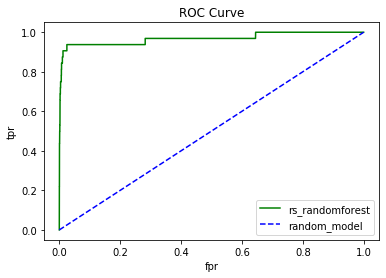

In [42]:
def plot_roc_curve(fpr,tpr):
    
    
    plt.plot(fpr,tpr,label='rs_randomforest',color='green')
    plt.plot([0,1],[0,1],label='random_model',color='blue',linestyle='--')
    plt.xlabel('fpr')
    plt.ylabel('tpr') 
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr,tpr)

In [43]:
roc_auc_score=auc(fpr,tpr)
roc_auc_score

0.9680328450694816

### So the Area under curve has a score of 96.8% on the test data which is very good, next is our feature importance

## Feature Importance

In [44]:
def plot_feature_importance(columns,importance,n=7):
    
    df=(pd.DataFrame({'features':columns,
                    'feature_importance':importance}).sort_values(by=['feature_importance'],ascending=False).reset_index(drop=True))
    fig,ax=plt.subplots()
    ax.barh(df['features'][:n],df['feature_importance'][:n])
    ax.set_ylabel('features')
    ax.set_xlabel('importances')
    ax.invert_yaxis()

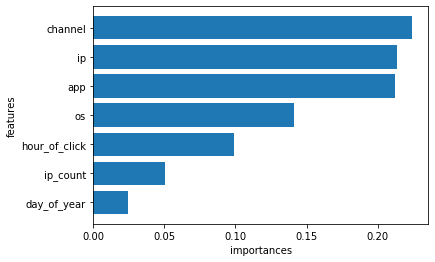

In [45]:
plot_feature_importance(x_test.columns,loaded_model.feature_importances_)

### Commentary:
we just carried out analysis and feature importance on the features. we are able to build a machine learning model that gives us an AUC score of 96.8% on unseen data.
And after feature engineering we are able to deduce the top 7 most important features that we can use in building another machine learning models